# Unlock the Power of Causal Inference: A Data Scientist's Guide to Understanding the Backdoor Adjustment Formula

## A fully working example of the backdoor adjustment formula using Python and the pgmpy library including a step-by-step explanation of the calculations

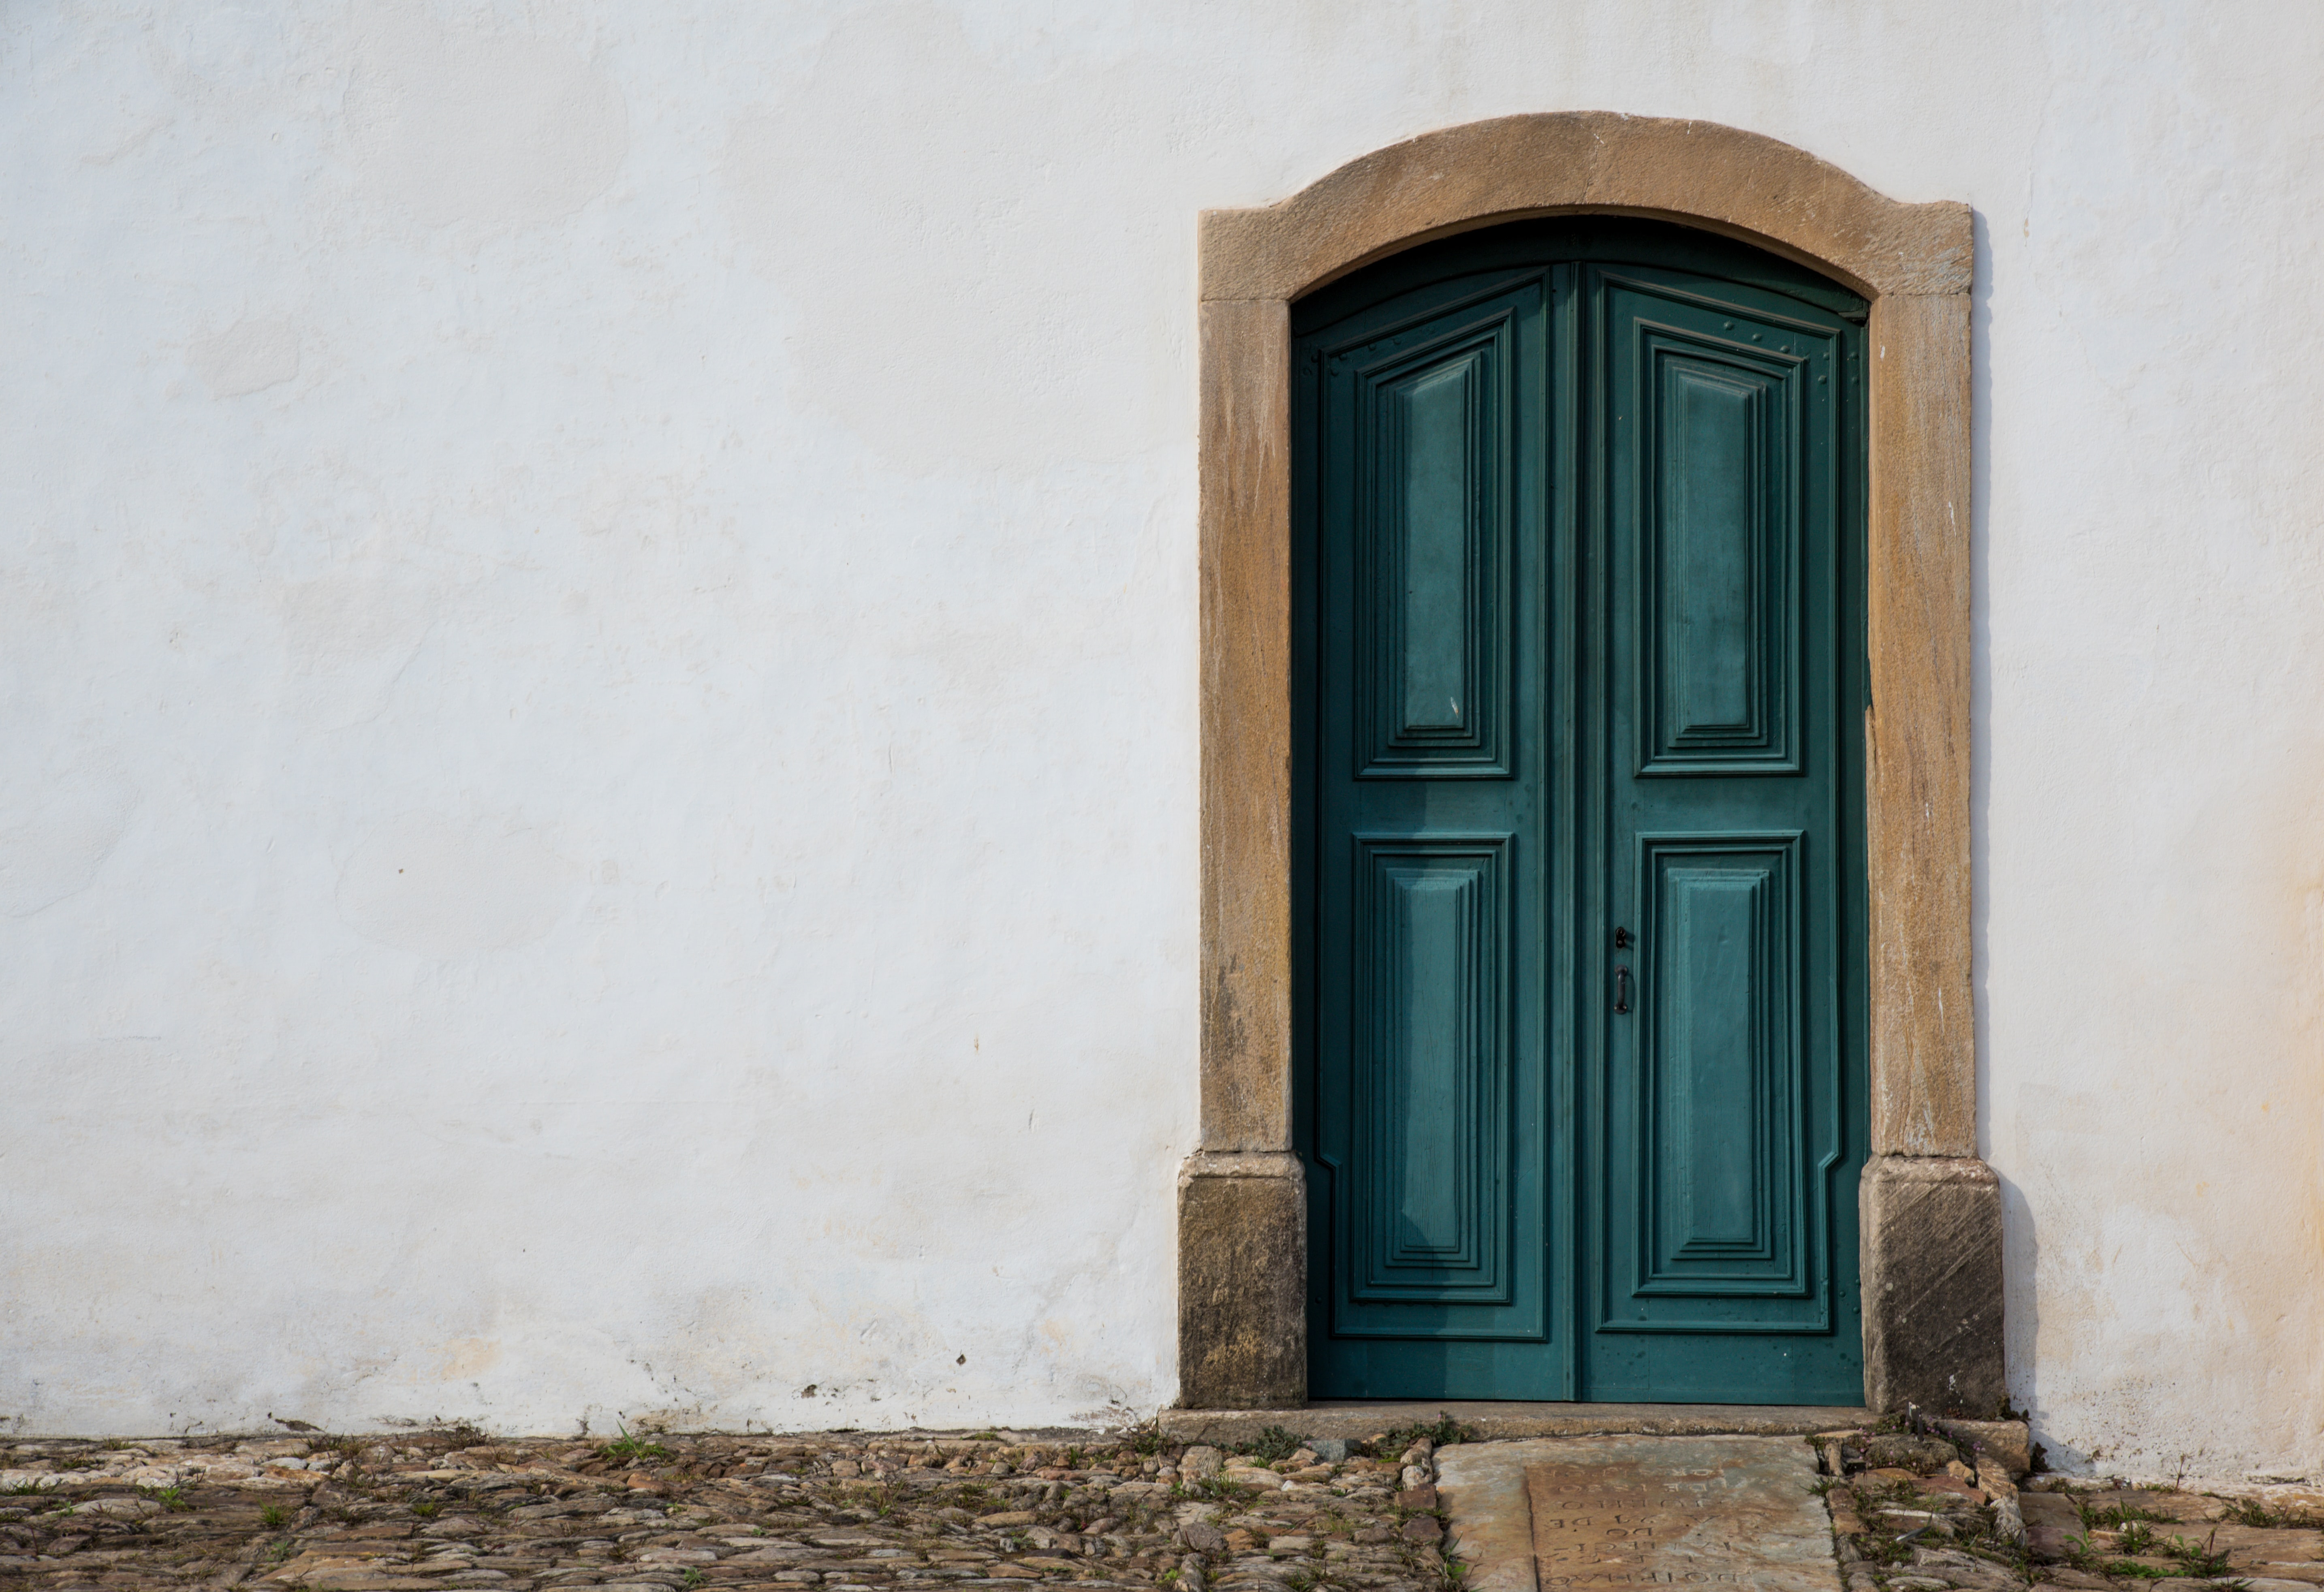

Photo by <a href="https://unsplash.com/@tamoio?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Roberto Huczek</a> on <a href="https://unsplash.com/s/photos/door?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>  

In [1]:
from cpt_tools import display_cpt
from dag_tools import DirectedAcyclicGraph

# Introduction
In probability theory it is very straight-forward to look at a dataset and calculate the probability of an event based on knowing something about other variables.

For example -

$$
p(Sale=1) = p(Click=1\ |\ Product\ Search=1)
$$

i.e. the probability of a sale is equal to the probability of a click on the link given that the product has been searched.

However, this approach breaks down when causal effects exists in the data and this is where causal inference comes in. There are a range of approaches depending on the pattern of causality and this article is going to focus on unlocking the power of the backdoor adjustment formula.

The "backdoor criteria" exists when the causal affect of X on Y is "confounded" by a third factor that influences both X and Y  ...

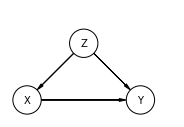

In [2]:
xyz_edges : list = [("Z", "X"), ("Z", "Y"), ("X", "Y")]
xyz_pos : dict = {"X": [1, 1], "Z": [2, 2], "Y": [3, 1]}    
    
xyz_dag = DirectedAcyclicGraph(edges=xyz_edges)
xyz_dag.display_pgm_model(pos=xyz_pos)

In this instance the formula $p(Y|X)$ does not work because of the confounding effect of Z and the backdoor adjustment formula needs to be applied from Pearlean "do" calculus to get the correct result -

$$
P(Y \mid do(X)) = \sum_{z} P(Y\mid X, Z=z)\ P(Z=z)
$$

This looks scarily complicated, especially to those who are new to "do" calculus but it is actually very easy to understand and apply.

By the end of this article you will understand how to apply the backdoor adjustment formula in ``Python`` and ``pgmpy``, why it is so powerful and what is happening behind the scenes.

## Getting Started

To get started we need some standard imports and a test dataset which is entirely synthetic and fictitious. 

The data is read in from a csv in the code below but if you would like to know how to generate synthetic binary data the following article provides a full explanation -https://towardsdatascience.com/how-to-generate-synthetic-data-for-any-causal-inference-project-in-less-than-10-lines-of-code-158688a89349.

In [3]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.inference import CausalInference

pd.set_option('display.precision', 8)

df_drug = pd.read_csv("data/drug_trial.csv")
df_drug

,male,drug,recovery
0,1,1,1
1,0,1,1
2,1,0,1
3,1,1,1
4,0,0,1
...,...,...,...
995,1,0,0
996,0,1,0
997,1,0,1
998,1,0,0


The synthetic data represents the results of a fictituous drug trial for 1000 subjects who all had a medical condition that the drug would be tested on. For example the first row represents a male (male=1) who took the drug (drug=1) and recovered (recovery=1).

## The Problem
Let's start by taking a quick look at the traditional probabilities in the data relating to recovery and patient outcomes using a single line of Python code -

In [4]:
df_drug.groupby(["drug"])["recovery"].value_counts(normalize=True)

drug  recovery
0     1           0.826
      0           0.174
1     1           0.778
      0           0.222
Name: recovery, dtype: float64

The result is that 77.8% of patients who took the drug recovered but 82.6% of patients who did not take the drug recovered. The traditional, probabilistic approach clearly suggests that the drug has a negative impact and that the drug trial should end.

However, there is causality between the features and that means that causal inference and the "do" operator need to be applied to establish the true effect.

## A Causal Solution

The cause-and-effect relationships in the data can be visualised using a simple Directed Acyclic Graph (or DAG) ..

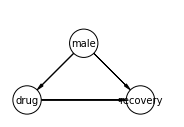

In [5]:
edges : list = [("male", "drug"), ("male", "recovery"), ("drug", "recovery")]
pos : dict = {"drug": [1, 1], "male": [2, 2], "recovery": [3, 1]}    
#pos={"drug": [0, 0], "male": [0.4, 0.02], "recovery": [0.8, 0]}
    
dag = DirectedAcyclicGraph(edges=edges)
dag.display_pgm_model(pos=pos)
#dag.display_networkx_model(pos=pos, node_size=2000, node_color="C0")

The code to create the DAG has been left out of this article but a full explanation can be found here - https://towardsdatascience.com/how-to-visualise-causal-inference-models-with-interactive-directed-acyclic-graphs-8dd648a64915.

The causal diagram shows that whilst taking the drug has a causal affect on recovery, it is not that simple. Gender (male) has a causal impact on both "drug" and "recovery" because ...

- A higher proportion of males decide to take the drug compared to females
- Males have a higher recovery rate than females

Therefore we must "deconfound" the affect of "male" from the affect of taking the drug to get the true affect.

The ideal scenario is that we travel back in time and force everyone to take the drug and measure the impact. We then travel back in time again and this time and prevent everyone from taking the drug. We then simply compare the two results and we have our answer!

However that solution suffers from the impossibility of time travel and the ethical, morale and legal aspects to forcing or preventing drug-taking.

There is a way forward though. It is the Pearlean "do" calculus which provides a formula for converting an interventional "do" into an equivalen formula containing only observational data which we know.

The remainder of this article is going to provide a simple causal solution using the ``pgmpy`` library and a second version which performs all the calculus by hand to show how it works.

### Solution 1: Using the Pgmpy Library
The first stage is to create a ``pgmpy`` causal model using the causal relationships defined in the Directed Acyclic Graph. ``Pgmpy`` creates a set of Conditional Probability Tables that describe the causal relationships which can easily be displayed to see what is going on ...

In [6]:
causal_model = BayesianNetwork([('male', 'drug'), ('male', 'recovery'), ('drug', 'recovery')])

causal_model.fit(df_drug)
causal_model.check_model()

True

The following code will call ``TabularCPD.__str__`` in the ``pgmpy`` library to display the conditional probability tables ...

In [7]:
for cpt in causal_model.get_cpds():
    print(cpt) 

+---------+------+
| male(0) | 0.49 |
+---------+------+
| male(1) | 0.51 |
+---------+------+
+---------+---------------------+---------------------+
| male    | male(0)             | male(1)             |
+---------+---------------------+---------------------+
| drug(0) | 0.23265306122448978 | 0.7568627450980392  |
+---------+---------------------+---------------------+
| drug(1) | 0.7673469387755102  | 0.24313725490196078 |
+---------+---------------------+---------------------+
+-------------+--------------------+-----+---------------------+
| drug        | drug(0)            | ... | drug(1)             |
+-------------+--------------------+-----+---------------------+
| male        | male(0)            | ... | male(1)             |
+-------------+--------------------+-----+---------------------+
| recovery(0) | 0.3157894736842105 | ... | 0.07258064516129033 |
+-------------+--------------------+-----+---------------------+
| recovery(1) | 0.6842105263157895 | ... | 0.9274193548387

... but I have displayed them below in a more visual and understandable format ...

In [8]:
for cpt in causal_model.get_cpds():
    display_cpt(cpt) # display_cpt is my own library built to improve the raw output of pgmpy and available in my public github 

Probability of male


,male,P
0,male(0),0.49
1,male(1),0.51


Probability of drug given male


"(male,)",drug(0),drug(1)
male(0),0.23265306,0.76734694
male(1),0.75686275,0.24313725


Probability of recovery given drug, male


('drug', 'male')  recovery(0)  recovery(1)
drug(0) male(0)    0.31578947   0.68421053
        male(1)    0.13212435   0.86787565
drug(1) male(0)    0.27127660   0.72872340
        male(1)    0.07258065   0.92741935

The next stage is to run the "do" operator twice on the model, once the drug=1 and again for drug=0. The second result can then be subtracted from the first to calculate the overall affect of taking the drug indepent and deconfounded from "male" ...

In [9]:
causal_inference = CausalInference(causal_model)

do_drug_1 = causal_inference.query(variables=["recovery"], do={"drug": 1}, show_progress=False)
do_drug_0 = causal_inference.query(variables=["recovery"], do={"drug": 0}, show_progress=False)

print(f"If the drug is taken by everyone p(recovery)={do_drug_1.get_value(recovery=1):.4}")
print(f"If the drug is not taken by anyone p(recovery)={do_drug_0.get_value(recovery=1):.4}")

print(f"\nThe improvement in recovery rate by everyone taking the drug is {do_drug_1.get_value(recovery=1) - do_drug_0.get_value(recovery=1):.1%}")    

If the drug is taken by everyone p(recovery)=0.8301
If the drug is not taken by anyone p(recovery)=0.7779

The improvement in recovery rate by everyone taking the drug is 5.2%


So ``pgmpy`` has been able to perform the magic trick of travelling back in time and re-running the drug trial. The first re-run forced everyone to take the drug, the second prevented anyone from taking the drug and then a simple subtraction provided the answer, but how does ``pgmpy`` work this magic? ...

### Solution 2: Manually Applying "do" Calculus

We have already concluded from the DAG that both "drug" and "recovery" are confounded by "male" and that in causal inference this pattern is referred to as the "backdoor" criteria.

The task therefore is to simulate an intervention (the time travel piece!) by writing a mathematical formula for the intervention and then to "adjust" it such that is is expressed in terms of data we can observe.

The backdoor adjustment formula from the "Introduction" section can be expressed as follows for the drug trial data -

$$
①\ \ \ \ \ p(Recovery=1 \mid do(Drug=1)) = \sum_{male} p(Recovery=1\mid Drug=1, Male=male) \times p(Male=male)
$$


From here it is a straight-forward task to calculate the overall effect of the drug as follows -

1. Calculate the effect of intervening or "do-ing" Drug=1 using the backdoor adjustment criteria.
2. Calculate the effect of intervening or "do-ing" Drug=0 using the backdoor adjustment criteria.
3. Subtract the result of part 2 from the result of part 1.
4. If the drug is having a positive impact the overall result will be a positive number.

The result is called the "Average Causal Effect" and can be denoted as follows -

$$
②\ \ \ \ \ \textbf{ACE} = p(Y=1 \mid do(X=1)) - p(Y=1 \mid do(X=0))
$$

... and in the drug example ...

$$
③\ \ \ \ \ \textbf{ACE} = p(Recovery=1 \mid do(Drug=1)) - p(Recovery=1 \mid do(Drug=0))
$$

Substituting the left and right side with the backdoor adjustment formula gives the following

$$
④\ \ \ \ \ \textbf{ACE} = \sum_{male} p(Recovery=1\mid Drug=1, Male=male) \times p(Male=male) - \\\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sum_{male} p(Recovery=1\mid Drug=0, Male=male) \times p(Male=male)
$$

So we need to solve the left side of the minus sign (i.e. the intervention where the drug is taken by everyone) by adding together the results for Male=1 and Male = 0 as follows -

$$
⑤\ \ \ \ \ p(Recovery=1\mid Drug=1, Male=1) \times p(Male=1) + p(Recovery=1\mid Drug=1, Male=0) \times p(Male=0)
$$


These probabilities could all be easily calculated directly from the ``df_drug`` ``DataFrame`` but they have already been nicely summarised for us in the conditional probabilitiy tables so they can be immediately substituted as follows ...

$$
⑥\ \ \ \ \ (0.92741935 \times 0.51 + 0.72872340 \times 0.49) = (0.4729838685 + 0.357074466) = \textbf{0.8301}
$$

Now we need to solve the right hand side of the minus sign in the expanded ACE formula (i.e. for the intervention where everyone is prevented from taking the drug) ...

$$
⑦\ \ \ \ \ p(Recovery=1\mid Drug=0, Male=1) \times p(Male=1) + p(Recovery=1\mid Drug=0, Male=0) \times p(Male=0)
$$

Again, we can just read off and substitute the probabilites from the conditional probability tables ..

$$
⑧\ \ \ \ \ (0.86787565 \times 0.51 + 0.68421053 \times 0.49) = (0.4426165815 + 0.3352631597) = \textbf{0.7779}
$$

The Average Causal Effect (ACE) can now be calculated by subtracting the second result from the first ...


$$
⑨\ \ \ \ \ \textbf{ACE} = 0.8301 - 0.7779 = \textbf{0.052}
$$

So the improvement in recovery rate by everyone taking the drug is $\textbf{5.2%}$ which exactly matches the calculations produced by using the ``pgmpy`` library!

## Conclusion
Traditional probabilistic approaches fail to produce the correct answers when causal relationships exist in data requiring causal techniques to calculate the correct results.

This article has used a synthetic dataset to show that the true effect of taking a drug on patient recovery was a positive impact of 5.2% when the traditional probabilistic approach suggested a negative impact of 5%.

To apply the causal inference techniques requires a "Directed Acyclic Graph" to define the causal relationships which is then used along with the dataset as an input to a causal calculation to show the true effect.

The ``pgmpy`` library performed the seemingly impossible magic trick of travelling back in time to intervene in the drug trial not once but twice, first forcing everyone to take the drug and then preventing anyone from taking the drug.

However, it is not magic. It is done by applying the "backdoor adjustment formula" as defined in Pearlean "do" calculus and the long-hand calculations were explained and then verified by matching the results back to the ``pgmpy`` library.

# Further Reading
If you would like to know more about the ``pgmpy`` library the full documentation can be found here: https://pgmpy.org/index.html.

And if you would like to know more about causal inference, this amazing book is a great place to get started: https://amzn.to/3iCVF8r

And this book provides a deeper and more detailed exploration of some of the key concepts: https://amzn.to/3WblFp1